In [85]:
pip install rapidfuzz


Note: you may need to restart the kernel to use updated packages.


In [96]:
pip install --upgrade typing_extensions


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install hdbscan sentence-transformers


   ---------------------------------------- 0.0/732.2 kB ? eta -:--:--
    --------------------------------------- 10.2/732.2 kB ? eta -:--:--
   ----------------- ---------------------- 327.7/732.2 kB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 732.2/732.2 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install pandas scikit-learn lightgbm joblib


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 13.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 11.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Load the first CSV file
file_path1 = r'C:\Users\mruga\Desktop\New folder\Capstone Project\AutoShopIQ_Repair_chatbot\Data\Invoices_converted_csv\all_repair_orders.csv'  # Replace with your first CSV file path
data1 = pd.read_csv(file_path1)

# Load the second CSV file
file_path2 = r'C:\Users\mruga\Desktop\New folder\Capstone Project\AutoShopIQ_Repair_chatbot\Data\Invoices_converted_csv\structured_repair_data.csv'  # Replace with your second CSV file path
data2 = pd.read_csv(file_path2)

# Display the first few rows of both datasets
print("First CSV file:")
# print(data1.head(10))

print("\nSecond CSV file:")
# print(data2.head(10))

First CSV file:

Second CSV file:


Exploring the data in the Structred CSV and If we need any columns from the csv we will extract them and merge with the strructred CSV i.e. data2  

Total unique concerns after cleaning: 4285


Batches:   0%|          | 0/134 [00:00<?, ?it/s]

c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\34574404.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_concerns['cluster_id'] = filtered_concerns['concern_normalized'].map(concern_cluster_map)
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\34574404.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

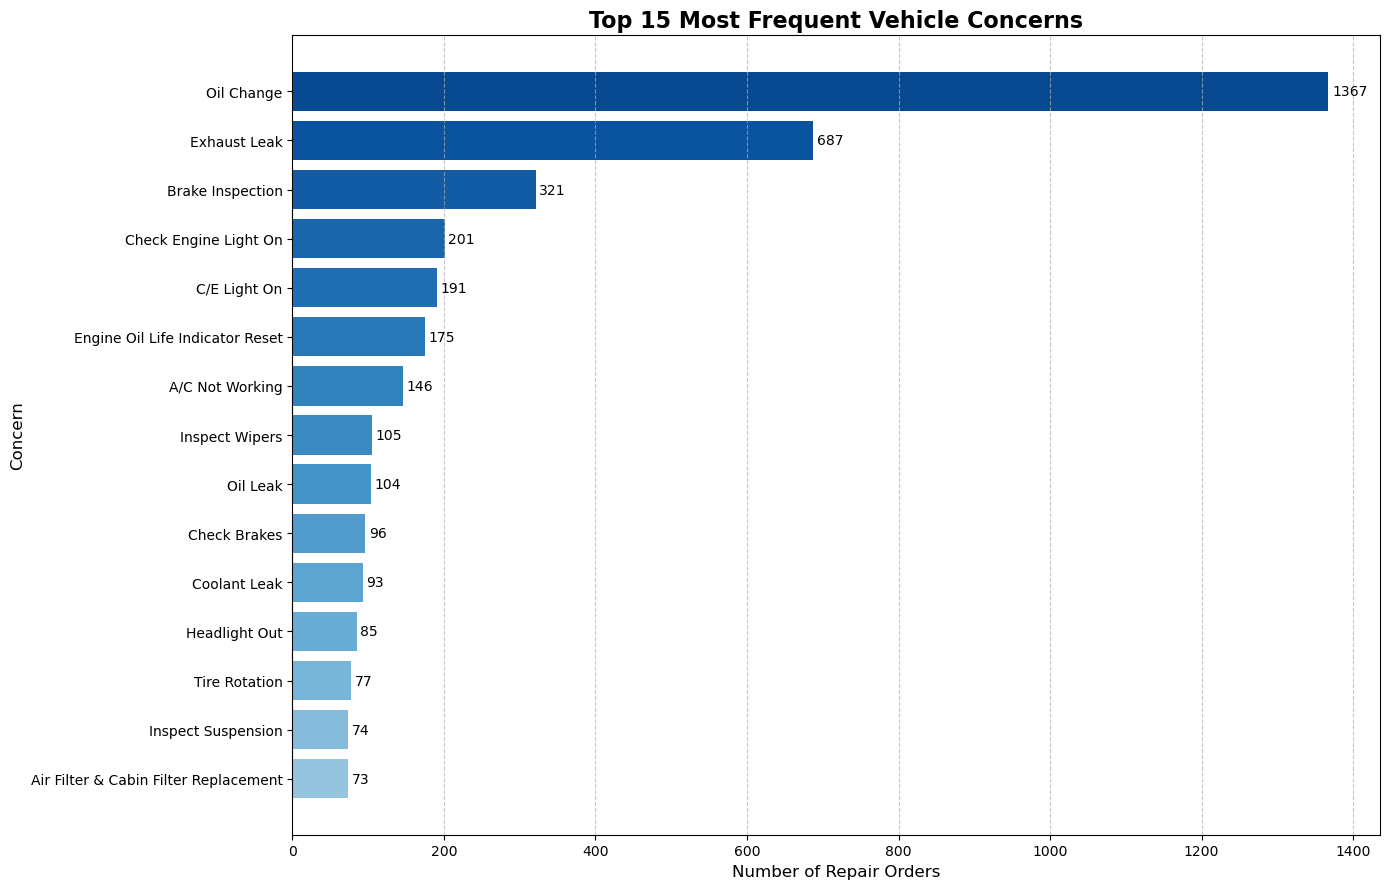


🔎 Clustering Summary:
Total unique concerns before clustering: 4285
Number of clustered concerns: 1201
Number of unclustered concerns: 3084
Number of clusters formed: 73
Total unique concern labels after combining clustered + raw unclustered: 3157


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np
import hdbscan

# Step 1: Normalize concerns (cleaning)
data2['concern_normalized'] = data2['concern'].str.lower().str.strip().str.title()

# Fix common typos before embedding
typo_corrections = {
    'Oil Flhange': 'Oil Change',
    'Brake Noisey': 'Brake Noise',
    'Check Eng Light Is On': 'Check Engine Light',
    'Exhaust=Leak': 'Exhaust Leak'
}
data2['concern_normalized'] = data2['concern_normalized'].replace(typo_corrections)

# Step 2: Drop duplicates on ro_number + concern
unique_ro_concerns = data2[['ro_number', 'concern_normalized']].drop_duplicates()

# Step 3: Filter out non-informative concerns
non_informative = ['No Technician Concerns Found.', 'No Customer Concerns Found.']
filtered_concerns = unique_ro_concerns[~unique_ro_concerns['concern_normalized'].isin(non_informative)]

# Step 4: Report number of unique concerns after cleaning
num_unique_concerns = filtered_concerns['concern_normalized'].nunique()
print(f"Total unique concerns after cleaning: {num_unique_concerns}")

# Step 5: Generate embeddings for clustering
model = SentenceTransformer('all-MiniLM-L6-v2')
unique_concerns = filtered_concerns['concern_normalized'].unique()
embeddings = model.encode(unique_concerns, show_progress_bar=True)

# Step 6: HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
cluster_labels = clusterer.fit_predict(embeddings)

# Step 7: Assign cluster labels and group by representative name
concern_cluster_map = dict(zip(unique_concerns, cluster_labels))
filtered_concerns['cluster_id'] = filtered_concerns['concern_normalized'].map(concern_cluster_map)

# Label each cluster using its most common term
cluster_names = (
    filtered_concerns[filtered_concerns['cluster_id'] != -1]
    .groupby('cluster_id')['concern_normalized']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# Step 8: Use cluster name if clustered, else keep original normalized concern
filtered_concerns['final_concern'] = filtered_concerns.apply(
    lambda row: cluster_names[row['cluster_id']] if row['cluster_id'] != -1 else row['concern_normalized'], axis=1
)

# Step 9: Count frequency of final concerns
final_concern_counts = filtered_concerns['final_concern'].value_counts().reset_index()
final_concern_counts.columns = ['concern', 'count']

# Step 10: Visualize top 30 concerns
import matplotlib.colors as mcolors
top_n = 15

# Create gradient shades of blue
colors = plt.cm.Blues(np.linspace(0.4, 0.9, top_n))

# Sort data for consistent bar coloring
top_concerns = final_concern_counts.head(top_n).iloc[::-1]

plt.figure(figsize=(14, 9))
bars = plt.barh(top_concerns['concern'], top_concerns['count'], color=colors)

plt.title(f"Top {top_n} Most Frequent Vehicle Concerns", fontsize=16, weight='bold')
plt.xlabel("Number of Repair Orders", fontsize=12)
plt.ylabel("Concern", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Step 11: Merge clustered concern names back into data2
data2 = data2.merge(filtered_concerns[['ro_number', 'concern_normalized', 'final_concern']], 
                    on=['ro_number', 'concern_normalized'], 
                    how='left')

# Step 12: Clustering summary
num_clustered = sum(cluster_labels != -1)
num_unclustered = sum(cluster_labels == -1)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_grouped_concerns = filtered_concerns['final_concern'].nunique()

print("\n🔎 Clustering Summary:")
print(f"Total unique concerns before clustering: {len(unique_concerns)}")
print(f"Number of clustered concerns: {num_clustered}")
print(f"Number of unclustered concerns: {num_unclustered}")
print(f"Number of clusters formed: {num_clusters}")
print(f"Total unique concern labels after combining clustered + raw unclustered: {num_grouped_concerns}")


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 Top Grouped Job Types Preview:
                            final_job_type  count
0                               Oil Change   1858
1                       General Diagnostic   1567
2                         Brake Inspection   1211
3                       Exhaust Inspection    643
4                   Alternator Replacement    161
5                         Bulb Replacement    151
6                      Battery Replacement    135
7          Used Vehicle General Inspection    134
8                Brake Pad & Rotor Package    105
9    Air Filter & Cabin Filter Replacement     96
10                            Wiper Blades     89
11   6 Or 8 Cylinder Flex Pipe Replacement     84
12                        Front Suspension     61
13                      Gasket Replacement     58
14                            Exhaust Leak     56
15                     Emissions Diagnosis     54
16                                     Eng     52
17                     Starter Replacement     51
18               

C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\1091243350.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_jobs['job_cluster_id'] = unique_jobs['job_type_normalized'].map(job_cluster_map)
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\1091243350.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_jobs['final_job_type'] = unique_jobs.apply(
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\1091243350.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Text(0.5, 1.0, 'Top 15 Most Frequent Job Types')

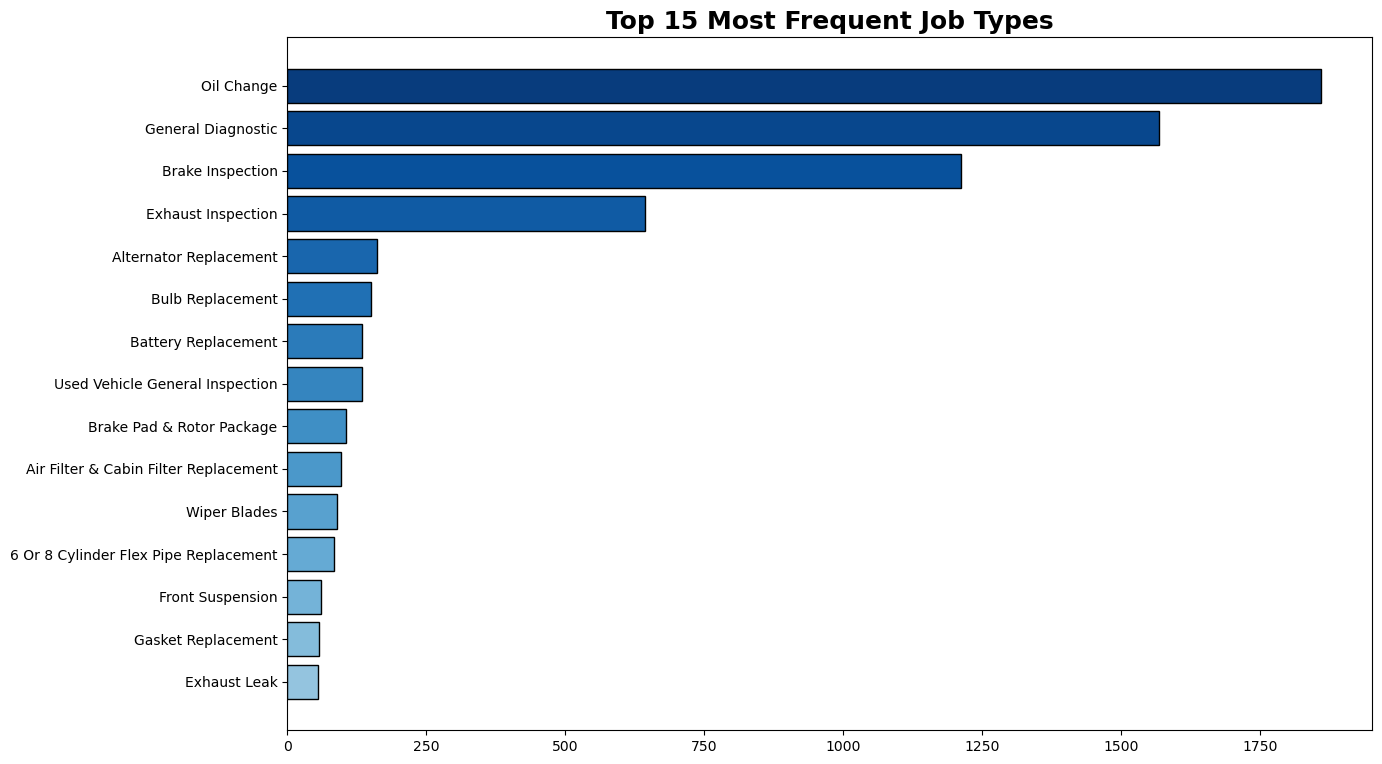

In [5]:
# Step 1: Normalize job_type column
job_data = data2[['ro_number', 'job_type']].dropna().copy()
job_data['job_type_normalized'] = job_data['job_type'].str.lower().str.strip().str.title()

# Step 2: Drop duplicates to get unique job_type entries per RO
unique_jobs = job_data.drop_duplicates()

# Step 3: Generate sentence embeddings for job types
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
unique_job_types = unique_jobs['job_type_normalized'].unique()
job_embeddings = model.encode(unique_job_types, show_progress_bar=True)

# Step 4: Cluster using HDBSCAN
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
job_labels = clusterer.fit_predict(job_embeddings)

# Step 5: Assign clusters and label grouped names
job_cluster_map = dict(zip(unique_job_types, job_labels))
unique_jobs['job_cluster_id'] = unique_jobs['job_type_normalized'].map(job_cluster_map)

# Representative label for each cluster
cluster_names = (
    unique_jobs[unique_jobs['job_cluster_id'] != -1]
    .groupby('job_cluster_id')['job_type_normalized']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# Step 6: Create final_job_type column
unique_jobs['final_job_type'] = unique_jobs.apply(
    lambda row: cluster_names[row['job_cluster_id']] if row['job_cluster_id'] != -1 else row['job_type_normalized'], axis=1
)

# Step 6.1: Apply manual merge rules to standardize similar job types
merge_rules = {
    'Diag' : 'General Diagnostic',   
    'General Diagnostic Fee': 'General Diagnostic',
    'Brake': 'Brake Inspection',
    'Oil C': 'Oil Change',
    'Full Synthetic Oil Change': 'Oil Change',
    'Exhaust Repair': 'Exhaust Inspection',
    'C/E Light On': 'Check Engine Light On',
    'Rear Brakes': 'Brake Inspection',
    'Scan For Codes': 'General Diagnostic',
    'Valve Cover Gasket Replacement': 'Gasket Replacement',
    'Muffler Replacement': 'Exhaust Inspection'
}
unique_jobs['final_job_type'] = unique_jobs['final_job_type'].replace(merge_rules)

# Step 7: Merge final job type into data2
# Ensure 'job_type_normalized' exists in data2
if 'job_type_normalized' not in data2.columns:
    data2['job_type_normalized'] = data2['job_type'].str.lower().str.strip().str.title()
data2 = data2.merge(unique_jobs[['ro_number', 'job_type_normalized', 'final_job_type']], 
                    on=['ro_number', 'job_type_normalized'], 
                    how='left')
# Preview top grouped job types for validation
job_type_counts = unique_jobs['final_job_type'].value_counts().reset_index()
job_type_counts.columns = ['final_job_type', 'count']
print("📊 Top Grouped Job Types Preview:")
print(job_type_counts.head(30))

# Step 7.1: Visualize top grouped job types
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Define how many top job types to show
top_n = 15
top_jobs = job_type_counts.head(top_n).iloc[::-1]

# Use aesthetically pleasing blue shades
blues = mpl.cm.get_cmap('Blues')
colors = blues(np.linspace(0.4, 0.95, top_n))

plt.figure(figsize=(14, 9))
bars = plt.barh(top_jobs['final_job_type'], top_jobs['count'], color=colors, edgecolor='black')

plt.title(f"Top {top_n} Most Frequent Job Types", fontsize=18, fontweight='bold')


Batches:   0%|          | 0/152 [00:00<?, ?it/s]

c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\96994542.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_labor['labor_cluster_id'] = unique_labor['labor_job_info_normalized'].map(labor_cluster_map)
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\96994542.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

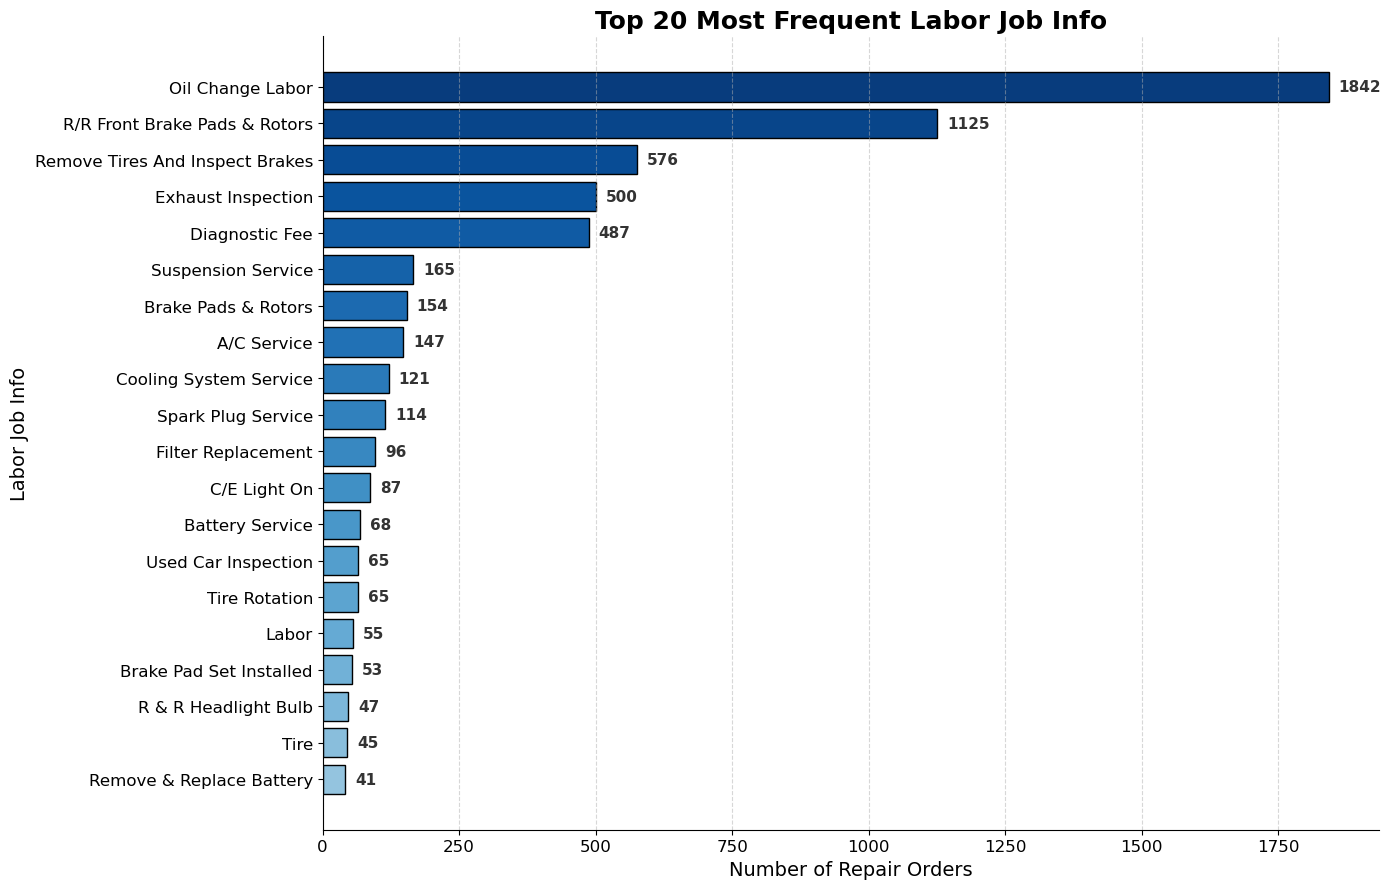

In [11]:
# Step 1: Normalize labor_job_info column
labor_data = data2[['ro_number', 'labor_job_info']].dropna().copy()
labor_data['labor_job_info_normalized'] = labor_data['labor_job_info'].str.lower().str.strip().str.title()

# Step 2: Drop duplicates to get unique entries per RO
unique_labor = labor_data.drop_duplicates()

# Step 3: Generate sentence embeddings
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
unique_labor_info = unique_labor['labor_job_info_normalized'].unique()
labor_embeddings = model.encode(unique_labor_info, show_progress_bar=True)

# Step 4: Cluster using HDBSCAN
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
labor_labels = clusterer.fit_predict(labor_embeddings)

# Step 5: Assign clusters and label grouped names
labor_cluster_map = dict(zip(unique_labor_info, labor_labels))
unique_labor['labor_cluster_id'] = unique_labor['labor_job_info_normalized'].map(labor_cluster_map)

# Representative label for each cluster
cluster_names = (
    unique_labor[unique_labor['labor_cluster_id'] != -1]
    .groupby('labor_cluster_id')['labor_job_info_normalized']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# Step 6: Create final_labor_job_info column
unique_labor['final_labor_job_info'] = unique_labor.apply(
    lambda row: cluster_names[row['labor_cluster_id']] if row['labor_cluster_id'] != -1 else row['labor_job_info_normalized'], axis=1
)

# Step 6.1: Apply manual merge rules to standardize similar labor job info
merge_rules = {
    'Oil C': 'Oil Change Labor',
    'Oil': 'Oil Change Labor',
    'Diag': 'Diagnostic Fee',
    'General Diagnostic Fee': 'Diagnostic Fee',
    'Labor, Remove Tires And Inspect Brakes': 'Remove Tires And Inspect Brakes',
    'R & R Battery': 'Battery Service',
    'R & R & Battery': 'Battery Service',
    'R&R Spark Plugs': 'Spark Plug Service',
    'R&R Left Rear Caliper & Bleed System': 'Brake Pads & Rotors',
    'R&R Radiator And Bleed System': 'Cooling System Service',
    'A/C Diag With Re-Charge': 'A/C Service',
    'Engine Oil Life Indicator Reset': 'A/C Service',
    'R&R Front Sway Bar Links': 'Suspension Service',
    '4 Cylinder Flex Pipe Replacement': 'Suspension Service',
    'R & R Air Filter And Cabin Filter': 'Filter Replacement',
    'Visually Inspect Exhaust System For Leaks': 'Exhaust Inspection',
    'Exhaust Labor': 'Exhaust Inspection',
    'Clean & Adjust Rear Brakes': 'Brake Pads & Rotors'
}
unique_labor['final_labor_job_info'] = unique_labor['final_labor_job_info'].replace(merge_rules)

# Step 6.2: Preview top grouped labor job info for validation
labor_job_counts = unique_labor['final_labor_job_info'].value_counts().reset_index()
labor_job_counts.columns = ['final_labor_job_info', 'count']
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Visualize top 20 grouped labor job info
top_n = 20
top_labor = labor_job_counts.head(top_n).iloc[::-1]
blues = mpl.cm.get_cmap('Blues')
colors = blues(np.linspace(0.4, 0.95, top_n))

plt.figure(figsize=(14, 9))
bars = plt.barh(top_labor['final_labor_job_info'], top_labor['count'], color=colors, edgecolor='black')

plt.title(f"Top {top_n} Most Frequent Labor Job Info", fontsize=18, fontweight='bold')
plt.xlabel("Number of Repair Orders", fontsize=14)
plt.ylabel("Labor Job Info", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

for bar in bars:
    width = bar.get_width()
    plt.text(width + max(top_labor['count']) * 0.01, bar.get_y() + bar.get_height() / 2, 
             str(int(width)), va='center', fontsize=11, fontweight='bold', color='#333333')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Step 7: Merge final labor job info into data2
if 'labor_job_info_normalized' not in data2.columns:
    data2['labor_job_info_normalized'] = data2['labor_job_info'].str.lower().str.strip().str.title()

data2 = data2.merge(unique_labor[['ro_number', 'labor_job_info_normalized', 'final_labor_job_info']], 
                    on=['ro_number', 'labor_job_info_normalized'], 
                    how='left')


In [ ]:
# Step 1: Normalize part_name column
part_data = data2[['ro_number', 'part_name']].dropna().copy()
part_data['part_name_normalized'] = part_data['part_name'].str.lower().str.strip().str.title()

# Step 2: Drop duplicates to get unique entries per RO
unique_parts = part_data.drop_duplicates()

# Step 3: Generate sentence embeddings
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
unique_part_names = unique_parts['part_name_normalized'].unique()
part_embeddings = model.encode(unique_part_names, show_progress_bar=True)

# Step 4: Cluster using HDBSCAN
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
part_labels = clusterer.fit_predict(part_embeddings)

# Step 5: Assign clusters and label grouped names
part_cluster_map = dict(zip(unique_part_names, part_labels))
unique_parts['part_cluster_id'] = unique_parts['part_name_normalized'].map(part_cluster_map)

# Representative label for each cluster
cluster_names = (
    unique_parts[unique_parts['part_cluster_id'] != -1]
    .groupby('part_cluster_id')['part_name_normalized']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# Step 6: Create final_part_name column
unique_parts['final_part_name'] = unique_parts.apply(
    lambda row: cluster_names[row['part_cluster_id']] if row['part_cluster_id'] != -1 else row['part_name_normalized'], axis=1
)

# Step 6.1: Preview top grouped part names for validation
part_name_counts = unique_parts['final_part_name'].value_counts().reset_index()
part_name_counts.columns = ['final_part_name', 'count']
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Visualize top 20 grouped part names
top_n = 20
top_parts = part_name_counts.head(top_n).iloc[::-1]
blues = mpl.cm.get_cmap('Blues')
colors = blues(np.linspace(0.4, 0.95, top_n))

plt.figure(figsize=(14, 9))
bars = plt.barh(top_parts['final_part_name'], top_parts['count'], color=colors, edgecolor='black')

plt.title(f"Top {top_n} Most Frequent Part Names", fontsize=18, fontweight='bold')
plt.xlabel("Number of Repair Orders", fontsize=14)
plt.ylabel("Part Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

for bar in bars:
    width = bar.get_width()
    plt.text(width + max(top_parts['count']) * 0.01, bar.get_y() + bar.get_height() / 2, 
             str(int(width)), va='center', fontsize=11, fontweight='bold', color='#333333')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Step 7: Merge final part name into data2
if 'part_name_normalized' not in data2.columns:
    data2['part_name_normalized'] = data2['part_name'].str.lower().str.strip().str.title()

data2 = data2.merge(unique_parts[['ro_number', 'part_name_normalized', 'final_part_name']], 
                    on=['ro_number', 'part_name_normalized'], 
                    how='left')


Batches:   0%|          | 0/137 [00:00<?, ?it/s]

c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mruga\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\1277492193.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_parts['part_cluster_id'] = unique_parts['part_name_normalized'].map(part_cluster_map)
C:\Users\mruga\AppData\Local\Temp\ipykernel_13164\1277492193.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

NameError: name 'part_name_counts' is not defined

In [ ]:
# Clean and transform vehicle model and mileage info in data2

# Step 1: Ensure 'model' column is clean and not null
data2['model'] = data2['model'].fillna('')

# Step 2: Split 'model' to extract 'trim'
data2['trim'] = data2['model'].apply(lambda x: ' '.join(x.split(' ')[1:]) if len(x.split(' ')) > 1 else None)

# Step 3: Update 'model' to keep only base model
data2['model'] = data2['model'].apply(lambda x: x.split(' ')[0])

# Step 4: Create single mileage column based on availability
data2['mileage'] = data2.apply(lambda row: row['mileage_out'] if pd.notna(row['mileage_out']) else row['mileage_in'], axis=1)

# Step 5: Show results
print(data2[['year', 'make', 'model', 'trim', 'mileage']].head())


     year           make  model  trim  mileage
0  1982.0  Mercedes-Benz  380SL  Base  90399.0
1  1982.0  Mercedes-Benz  380SL  Base  90399.0
2  1982.0  Mercedes-Benz  380SL  Base  90399.0
3  1982.0  Mercedes-Benz  380SL  Base  90399.0
4  1982.0  Mercedes-Benz  380SL  Base  90399.0


In [ ]:
print("Columns in data2:")
print(data2.columns)

Columns in data2:


NameError: name 'data2' is not defined

ro_number /n
customer_name
vehicle - Year, Make model trim
vehicle_issues
service_writer
technician
labor_rate
customer_time_in
promised_time_out
marketing_source
appointment_option
jobs
Financials_Overall
pdf_name

In [7]:
# Predict job type and part name using TF-IDF + LightGBM classifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np

# Load structured data
data = data2.copy()

# Fill missing values
for col in ['final_concern', 'make', 'model', 'trim', 'final_job_type', 'final_part_name']:
    data[col] = data[col].fillna('unknown')

data['mileage'] = data['mileage_out'].fillna(data['mileage_in'])

# Filter rare job types (less than 30 samples)
job_counts = data['final_job_type'].value_counts()
valid_jobs = job_counts[job_counts >= 30].index
data = data[data['final_job_type'].isin(valid_jobs)]

# Filter rare part names (less than 30 samples)
part_counts = data['final_part_name'].value_counts()
valid_parts = part_counts[part_counts >= 30].index
data = data[data['final_part_name'].isin(valid_parts)]

# Combine features
data['vehicle_info'] = data['make'] + ' ' + data['model'] + ' ' + data['trim'] + ' ' + data['year'].astype(str)
data['full_input'] = data['vehicle_info'] + ' | ' + data['final_concern'] + ' | Mileage: ' + data['mileage'].astype(str)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=300)
X = vectorizer.fit_transform(data['full_input'])

# ---- JOB TYPE PREDICTION ----
le_job = LabelEncoder()
y_job = le_job.fit_transform(data['final_job_type'])

# Compute class weights inversely proportional to frequencies
job_class_weights = (1 / job_counts[le_job.inverse_transform(np.unique(y_job))]).to_dict()
job_weights_array = np.array([job_class_weights[le_job.inverse_transform([y])[0]] for y in y_job])

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y_job, job_weights_array, test_size=0.2, random_state=42)

job_clf = LGBMClassifier(num_leaves=64, min_data_in_leaf=20, learning_rate=0.1, max_depth=-1, n_estimators=100, verbosity=-1)
job_clf.fit(X_train, y_train, sample_weight=w_train)
y_pred_job = job_clf.predict(X_test)

print("\n--- Job Type Prediction ---")
print("Accuracy:", accuracy_score(y_test, y_pred_job))
labels_in_test = sorted(list(set(y_test)))
print(classification_report(y_test, y_pred_job,
                            labels=labels_in_test,
                            target_names=le_job.inverse_transform(labels_in_test)))

# ---- PART NAME PREDICTION ----
le_part = LabelEncoder()
y_part = le_part.fit_transform(data['final_part_name'])

# Compute class weights for parts
part_class_weights = (1 / part_counts[le_part.inverse_transform(np.unique(y_part))]).to_dict()
part_weights_array = np.array([part_class_weights[le_part.inverse_transform([y])[0]] for y in y_part])

X_train_p, X_test_p, y_train_p, y_test_p, w_train_p, w_test_p = train_test_split(X, y_part, part_weights_array, test_size=0.2, random_state=42)

part_clf = LGBMClassifier(num_leaves=64, min_data_in_leaf=20, learning_rate=0.1, max_depth=-1, n_estimators=100, verbosity=-1)
part_clf.fit(X_train_p, y_train_p, sample_weight=w_train_p)
y_pred_part = part_clf.predict(X_test_p)

print("\n--- Part Name Prediction ---")
print("Accuracy:", accuracy_score(y_test_p, y_pred_part))
labels_in_test_p = sorted(list(set(y_test_p)))
print(classification_report(y_test_p, y_pred_part,
                            labels=labels_in_test_p,
                            target_names=le_part.inverse_transform(labels_in_test_p)))

# Save models and encoders
joblib.dump(job_clf, "job_type_lightgbm_model.pkl")
joblib.dump(le_job, "job_type_label_encoder.pkl")
joblib.dump(part_clf, "part_name_lightgbm_model.pkl")
joblib.dump(le_part, "part_name_label_encoder.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


KeyError: 'trim'